In [16]:
import sys
import os
import shutil
import json
import numpy as np

current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])
sys.path.append(new_directory)

## Post processing framework

#### Simulation Name

In [17]:
simulation_name = 'Main'
simulation_folder = 'tests'

results_dir = os.path.sep.join(path_components[:-2])
results_path = os.path.join(results_dir,'.results',simulation_folder,simulation_name)
results_path = os.path.join(results_dir,'code','results',simulation_name)

main_path = os.path.join(results_dir,'code')
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_temp.py'))
print(main_path)
print(results_path)

/home/martinachondo/PINN/code
/home/martinachondo/PINN/code/results/Main


In [18]:
folder_name = 'S_temp'
folder_path = os.path.join(main_path,'results',folder_name)

from S_temp import simulation

simulation.create_simulation()
print(simulation.domain_properties)



 <<INFO>> Starting NanoShaper 0.7.8
 <<INFO>> Loading atoms....
 <<INFO>> Read 27 atoms
 <<INFO>> Geometric baricenter ->  -0.136 0.5195 0.4945
 <<INFO>> Grid is 23
 <<INFO>> MAX 5.364 6.0195 5.9945
 <<INFO>> MIN -5.636 -4.9805 -5.0055
 <<INFO>> Perfil 90 %
 <<INFO>> Rmaxdim 10.065
 <<INFO>> Allocating memory...ok!
 <<INFO>> Initialization completed
 <<INFO>> Adjusting self intersection grid 
 <<INFO>> Self intersection grid is (before) 7
 <<INFO>> Self intersection grid is 4
 <<INFO>> Allocating self intersection grid....ok!
 <<INFO>> Computing alpha shape complex....ok!
 <<INFO>> Checking 0 probes for self intersections...ok!
 <<INFO>> Surface build-up time.. 0 [s]
 <<INFO>> Probe Radius value 1.4
 <<INFO>> Number of ses cells -> 117
 <<INFO>> Number of del_point cells -> 20
 <<INFO>> Number of regular del_edge cells -> 55
 <<INFO>> Number of singular del_edge cells -> 0
 <<INFO>> Number of regular del_facet cells -> 34
 <<INFO>> Number of singular del_facet cells -> 4
 <<INFO>> Us

In [19]:
Iter = 10
simulation.load_model(folder_path,results_path,Iter, save=False)
Post = simulation.Post

In [8]:
df = Post.save_values_file(save=False)
print(json.dumps(df, indent=4))

{
    "Gsolv_value": "2952.727",
    "L2_continuity_u": "1.054e-01",
    "L2_continuity_du": "8.264e-02",
    "Loss_XPINN": "3.393e+00",
    "Loss_NN1": "3.331e+00",
    "Loss_NN2": "8.077e-02"
}


In [6]:
Post.PDE.get_solvation_energy(Post.XPINN.model)

1465.9475188529552

In [16]:
Post.plot_aprox_analytic(value='react')

AttributeError: 'Postprocessing' object has no attribute 'plot_aprox_analytic'

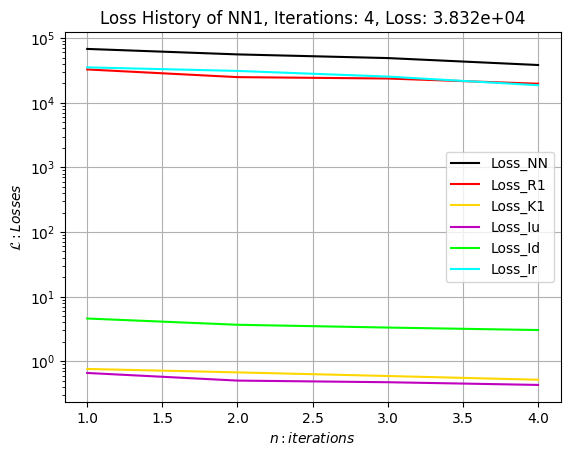

In [ ]:
Post.plot_loss_history(domain=1)

#### Computations

In [14]:
import bempp.api

u_interface,_,_ = Post.PDE.get_phi_interface(*Post.NN)
u_interface = u_interface.flatten()
_,du_1,du_2 = Post.PDE.get_dphi_interface(*Post.NN)
du_1 = du_1.flatten()
du_2 = du_2.flatten()
du_1_interface = (du_1+du_2*Post.NN[1].PDE.epsilon/Post.NN[0].PDE.epsilon)/2

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

phi_q = Post.PDE.slp_q * dphi - Post.PDE.dlp_q * phi

slp_aprox = Post.PDE.slp_q * dphi
dlp_aprox = Post.PDE.dlp_q * phi

In [15]:
print('slp',slp_aprox)
print('dlp', dlp_aprox)

slp [[-0.04577357]]
dlp [[-0.00114817]]


In [16]:
Rs = np.linalg.norm(Post.PDE.mesh.mol_verts, axis=1)

u_interface = Post.PDE.analytic_Born_Ion(Rs)
du_1_interface = Post.PDE.analytic_Born_Ion_du(Rs)

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

slp_an = Post.PDE.slp_q * dphi
dlp_an = Post.PDE.dlp_q * phi

In [17]:
print('slp',slp_an)
print('dlp', dlp_an)

slp [[-0.07938546]]
dlp [[-0.00094506]]


In [18]:
def get_Gsolv(slp,dlp):
  phi_q = slp - dlp
  G_solv = 0.5*np.sum(Post.PDE.qs * phi_q).real
  G_solv *= Post.PDE.to_V*Post.PDE.qe*Post.PDE.Na*(10**-3/4.184) 
  return G_solv

In [19]:
print('aprox',get_Gsolv(slp_aprox,dlp_aprox))
print('an',get_Gsolv(slp_an,dlp_an))

aprox -93.10722575405698
an -163.65945134158008


In [20]:
print('ap-an',get_Gsolv(slp_aprox,dlp_an))
print('an-ap',get_Gsolv(slp_an,dlp_aprox))

ap-an -93.53099959788352
an-ap -163.23567749775356


### Mesh

In [87]:
mol_mesh = Post.mesh.mol_mesh

In [88]:
X_plot = dict()
X_plot['Inner Domain'] = Post.mesh.region_meshes['R1'].vertices
X_plot['Inner Domain Sample'] = Post.mesh.region_meshes['R1'].get_dataset().numpy()

X_plot['Charges'] = Post.mesh.prior_data['Q1'].numpy()

X_plot['Interface'] = Post.mesh.region_meshes['I'].vertices
X_plot['Interface Sample'] = Post.mesh.region_meshes['I'].get_dataset().numpy()

X_plot['Outer Domain'] = Post.mesh.region_meshes['R2'].vertices
X_plot['Outer Domain Sample'] = Post.mesh.region_meshes['R2'].get_dataset().numpy()

X_plot['Outer Border'] = Post.mesh.region_meshes['D2'].vertices
X_plot['Outer Border Sample'] = Post.mesh.region_meshes['D2'].get_dataset().numpy()

In [89]:
s = mol_mesh.contains(X_plot['Inner Domain'])
st = 0
sf = 0
print('check')
for i in range(len(s)):
    if s[i]==True:
        st+=1
    else:
        sf+=1
print(st,sf)

check
886 1115


In [90]:
X_plot['Interface'].shape

(1190, 3)

In [28]:
mol_mesh.contains([[-1.03100002,  3.8440001 ,  3.13700008]])

array([False])

In [36]:
X_plot['Inner Domain Sample'][~s]

array([], shape=(0, 3), dtype=float32)

In [5]:
Post.mesh.R_mol

2.513355936062254

In [6]:
Post.mesh.R_max_dist

2.5430709609977082

In [7]:
np.linalg.norm(Post.mesh.centroid)

0.24322911894850144

In [15]:
mol_mesh.vertices

TrackedArray([[ 1.61099994,  0.        , -0.359     ],
              [ 1.403     ,  0.        , -0.93300003],
              [ 1.47500002,  0.        , -0.634     ],
              ...,
              [-1.52199996,  0.54100001, -1.04900002],
              [-1.62100005, -0.16      , -1.01400006],
              [-1.62100005,  0.16      , -1.01400006]])

In [16]:
Post.PDE.q_list

[Charges(q=0.27, x_q=array([99.7104,  0.    ,  0.8973]), r_q=1.8875, atom_name='CH3', res_name='MEOH', res_num='1', ion_r_explode=3.5),
 Charges(q=-0.7, x_q=array([99.5716,  0.    , -0.4955]), r_q=1.535, atom_name='O', res_name='MEOH', res_num='1', ion_r_explode=3.5),
 Charges(q=0.43, x_q=array([100.4284,   0.    ,  -0.8973]), r_q=0.2, atom_name='H', res_name='MEOH', res_num='1', ion_r_explode=3.5)]

In [17]:
Post.mesh.mol_verts

array([[ 1.611,  0.   , -0.359],
       [ 1.403,  0.   , -0.933],
       [ 1.475,  0.   , -0.634],
       ...,
       [-1.522,  0.541, -1.049],
       [-1.621, -0.16 , -1.014],
       [-1.621,  0.16 , -1.014]], dtype=float32)

In [18]:
Post.mesh.region_meshes['R1'].elements

array([[ 81, 100, 103, 104],
       [ 97,  98, 101, 114],
       [  1,  26,  72,  98],
       ...,
       [ 13,  68,  84, 106],
       [ 37,  82,  90, 105],
       [  1,   8,  85, 110]])

In [5]:
vertices = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
])
elements = np.array([
    [0, 1, 2, 3]
])

In [20]:
vertices = Post.mesh.region_meshes['R1'].vertices
elements = Post.mesh.region_meshes['R1'].elements

In [81]:
import plotly.graph_objects as go
import numpy as np

def plot_element(vertices, elements, element_idx):
    # Extract coordinates
    x = vertices[:, 0]
    y = vertices[:, 1]
    z = vertices[:, 2]

    # Define the trace for vertices
    trace_vertices = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=1,
            color='rgb(255,0,0)',  # Red color for vertices
            opacity=1
        )
    )

    # Define the trace for edges of the specified element
    edges = set()
    if elements.shape[1] == 4:  # Tetrahedral mesh
        for i in range(4):
            for j in range(i+1, 4):
                edge = tuple(sorted([elements[element_idx, i], elements[element_idx, j]]))
                edges.add(edge)
    elif elements.shape[1] == 3:  # Triangular mesh
        for i in range(3):
            for j in range(i+1, 3):
                edge = tuple(sorted([elements[element_idx, i], elements[element_idx, j]]))
                edges.add(edge)

    edge_x = []
    edge_y = []
    edge_z = []
    for edge in edges:
        edge_x += [x[edge[0]], x[edge[1]], None]
        edge_y += [y[edge[0]], y[edge[1]], None]
        edge_z += [z[edge[0]], z[edge[1]], None]

    trace_edges = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode='lines',
        line=dict(
            color='rgb(0,0,0)',  # Black color for edges
            width=2
        )
    )

    # Define the trace for elements
    x = vertices[elements[element_idx], 0]
    y = vertices[elements[element_idx], 1]
    z = vertices[elements[element_idx], 2]
    trace_vertices_2 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color='rgb(0,222,0)',  # Green color for vertices
            opacity=1
        )
    )

    # Create the plot
    fig = go.Figure(data=[trace_vertices, trace_edges, trace_vertices_2])

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        )
    )

    # Show the plot
    fig.show()

# For Tetrahedral Mesh

In [128]:
plot_element(Post.mesh.region_meshes['R1'].vertices, Post.mesh.region_meshes['R1'].elements, 234)

In [130]:
plot_element(Post.mesh.region_meshes['D2'].vertices, Post.mesh.region_meshes['D2'].elements, 300)

In [121]:
iter_cell = Post.mesh.region_meshes['R1'].obj.cellIDs
for num,i in enumerate(iter_cell):
    pass
i.indices()

[204, 669, 1441, 2000]

In [123]:
np.min(elements)

0

In [104]:
vertices = Post.mesh.region_meshes['R1'].vertices
elements = Post.mesh.region_meshes['R1'].elements
elements[11]

array([1218, 1372, 1463, 1958])

In [98]:
vertices[[204, 669, 1441, 2000]]

array([[-0.56966651,  1.34956132, -1.80346509],
       [-1.15053722,  3.15562968,  0.14476321],
       [ 1.64900005,  2.60500002, -3.20900011],
       [ 2.125     ,  2.26099992, -3.10400009]])

In [118]:
Post.mesh.region_meshes['R1'].obj.nCells

8404